#Description:
    *Merging raw reads with PEAR
        

#Setting variables




In [9]:
seqDir = '/var/seq_data/RhizCG/150522_run1_rerun/raw/'

readFile1 = 'read1.fq.gz'
readFile2 = 'read2.fq.gz'

#Init

In [12]:
import os
import screed
import matplotlib.pyplot as plt
from mpltools import style
import numpy as np
from mpld3 import enable_notebook
import screed
import ggplot

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning: `scipy.linalg.calc_lwork` is deprecated!

calc_lwork was an internal module in Scipy and has been removed.

Several functions in scipy.linalg.lapack have *_lwork variants
that perform the lwork calculation (from Scipy >= 0.15.0), or
allow passing in LWORK=-1 argument to perform the computation.


  warnings.warn(depdoc, DeprecationWarning)


In [16]:
%load_ext pylab
%load_ext rpy2.ipython

The pylab module is not an IPython extension.
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [36]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

##uncompressing 

In [5]:
!cd $seqDir; \
    pigz -k -d -p 24 read?.fq.gz

#Merging

In [6]:
!cd $seqDir; \
    pear -m 500 -j 24 \
    -f read1.fq \
    -r read2.fq \
    -o pear_merged-$(date +%F)

 ____  _____    _    ____ 
|  _ \| ____|  / \  |  _ \
| |_) |  _|   / _ \ | |_) |
|  __/| |___ / ___ \|  _ <
|_|   |_____/_/   \_\_| \_\

PEAR v0.9.2 [March 26 2014]

Citation - PEAR: a fast and accurate Illumina Paired-End reAd mergeR
Zhang et al (2014) Bioinformatics 30(5): 614-620 | doi:10.1093/bioinformatics/btt593

Forward reads file.................: read1.fq
Reverse reads file.................: read2.fq
PHRED..............................: 33
Using empirical frequencies........: YES
Statistical method.................: OES
Maximum assembly length............: 500
Minimum assembly length............: 50
p-value............................: 0.010000
Quality score threshold (trimming).: 0
Minimum read size after trimming...: 1
Maximal ratio of uncalled bases....: 1.000000
Minimum overlap....................: 10
Scoring method.....................: Scaled score
Threads............................: 24

Allocating memory..................: 200,000,000 bytes
Computing empirical frequen

#Making a screed db of merged read

In [7]:
pear_merged_file = !echo "pear_merged-"$(date +%F)".assembled.fastq"
pear_merged_file = pear_merged_file[0]

os.chdir(seqDir)
screed.read_fastq_sequences(pear_merged_file)

pear_merged_file += '_screed'
fqdb = screed.ScreedDB(pear_merged_file)

In [10]:
pear_merged_file = seqDir + 'pear_merged-2015-06-03.assembled.fastq_screed'
fqdb = screed.ScreedDB(pear_merged_file)

In [8]:
pear_merged_file 

'pear_merged-2015-06-03.assembled.fastq_screed'

In [11]:
lengths = []
for read in fqdb.itervalues():
    lengths.append((len(read["sequence"])))

In [17]:
style.use("ggplot")
fig = plt.figure()
ax = fig.add_subplot(111)
h = ax.hist(np.array(lengths), bins=50)
xl = ax.set_xlabel("Sequence Length, nt")
yl = ax.set_ylabel("Count")
fig.set_size_inches((10,6))

RuntimeError: Invalid DISPLAY variable

In [16]:
print 'Number of reads: {}'.format(len(lengths))

Number of reads: 8401290


#Quality stats on merged reads

In [18]:
def qualStats(sourceDir, fileName):
    outFile = fileName + '_qualStats'
    !cd $sourceDir; \
        fastx_quality_stats -i $fileName -o $outFile -Q 33
    return outFile
    
qualStatsRes = qualStats(seqDir, 'pear_merged-2015-06-03.assembled.fastq')

In [19]:
qualStatsRes = seqDir + 'pear_merged-2015-06-03.assembled.fastq_qualStats'

In [20]:
%%R -i seqDir -i qualStatsRes

setwd(seqDir)

# reading in qual-stats files    
tbl.r12 = read.delim(qualStatsRes, sep='\t')
rownames(tbl.r12) = 1:nrow(tbl.r12)

In [32]:
%%R
tbl.r12 %>% head

  column   count min max       sum  mean Q1 med Q3 IQR lW rW A_Count C_Count
1      1 8401290  16  40 234021219 27.86 29  29 32   3 25 36 1069040 1006446
2      2 8401290  16  40 251282355 29.91 29  32 32   3 25 36 6392026  760498
3      3 8401290  16  40 281119631 33.46 32  32 40   8 20 40  741557 6426952
4      4 8401290   2  40 305031854 36.31 32  40 40   8 20 40 2711878  596409
5      5 8401290   2  40 294364257 35.04 32  40 40   8 20 40 1198954  537426
6      6 8401290   2  40 308839705 36.76 35  40 40   5 28 40 5822239  580527
  G_Count T_Count N_Count Max_count
1 2450709 3875095       0   8401290
2  570816  677950       0   8401290
3  534827  697954       0   8401290
4 4427100  665902       1   8401290
5 4073683 2591219       8   8401290
6 1330531  667991       2   8401290


geom_smooth: method="auto" and size of largest group is <1000, so using loess. Use 'method = x' to change the smoothing method.


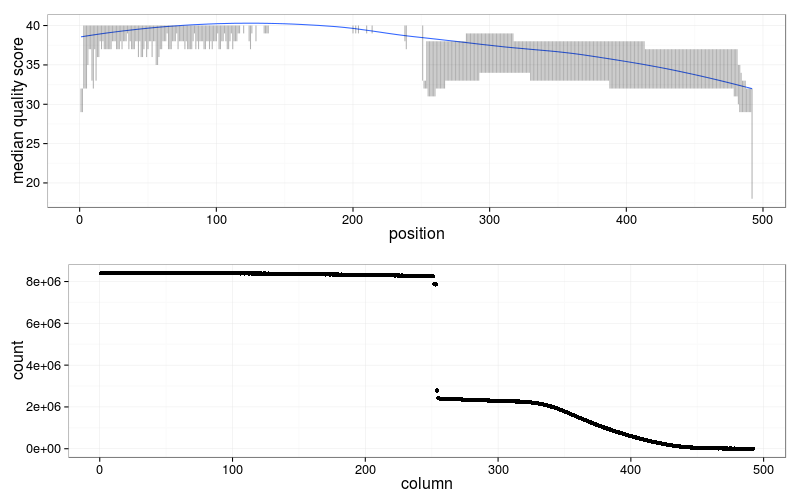

In [30]:
%%R -w 800 -h 500

# smooth curve on median qual values
p1 = ggplot(tbl.r12, aes(x=column, y=med, ymin=Q1, ymax=Q3)) +
    geom_smooth(se=FALSE) +
    geom_linerange(alpha=0.3) +
    labs(x='position', y='median quality score') +
    theme_bw() +
    theme( text = element_text(size=16) )

p2 = ggplot(tbl.r12, aes(x=column, y=count)) +
    geom_point() +
    theme_bw() +
    theme( text = element_text(size=16) )

grid.arrange(p1, p2, ncol=1)

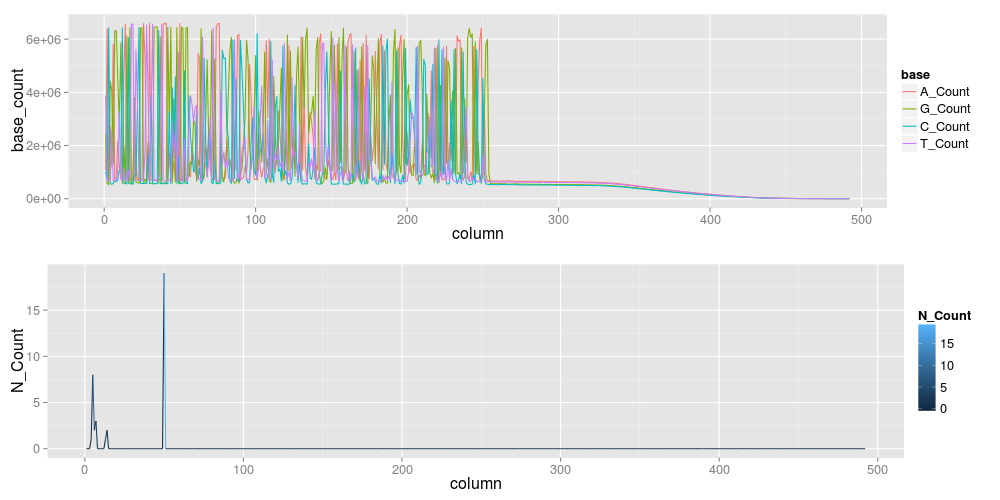

In [42]:
%%R -w 1000 -h 500

tbl.ATGC = tbl.r12 %>%
    select(column, A_Count, G_Count, C_Count, T_Count) %>%
    gather(base, base_count, -column)

tbl.N = tbl.r12 %>%
    select(column, N_Count)


#tbl.ATGC %>% head

p1 = ggplot(tbl.ATGC, aes(x=column, y=base_count, color=base)) +
    geom_line() +
    theme( text = element_text(size=16) )    


p2 = ggplot(tbl.N, aes(x=column, y=N_Count, color=N_Count)) +
    geom_line() +
    theme( text = element_text(size=16) )    

grid.arrange(p1,p2,ncol=1)